In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import argparse
import matplotlib.pyplot as plt
import argparse

In [37]:
#@title
def unflatten_coeff(coeff, shape):
    return coeff.unflatten(-1, (-1, *[1 for _ in shape[1:]]))


def get_dataset(name='swiss_roll', n_samples=100000):

    x = None
    if name == 'swiss_roll':
        from sklearn.datasets import make_swiss_roll
        x = make_swiss_roll(n_samples=n_samples, noise=0.05)[0][:,[0, 2]]
    
    elif name == 's_curve':
        from sklearn.datasets import make_s_curve
        x = make_s_curve(n_samples=n_samples, noise=0.05)[0][:,[0, 2]]
    
    elif name == 'circles':
        from sklearn.datasets import make_circles
        x = make_circles(n_samples=n_samples, factor=0.5, noise=0.1)[0]
    
    elif name == 'moons':
        from sklearn.datasets import make_moons
        x = make_moons(n_samples=n_samples, noise=0.05)[0]
        
    else:
        raise ValueError(f'not implemented {name} ')

    
    class DataSet(torch.utils.data.Dataset):
        def __init__(self, x):
            xmin, xmax = x.min(axis=0)[0], x.max(axis=0)[0]
            x = (x - xmin) / (xmax - xmin)
            x = 2. * x - 1.
            self.x = torch.FloatTensor(x)

        def __len__(self):
            return len(self.x)

        def __getitem__(self, idx):
            return self.x[idx]

    return DataSet(x)


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt


class GaussianFourierProjection(nn.Module):
    def __init__(self, temb_dim, scale=5.):
        super().__init__()
        self.w = nn.Parameter(torch.randn(1, temb_dim // 2) * scale, requires_grad=False)
    
    def forward(self, t):
        wt = self.w * t.unsqueeze(dim=-1) * 2. * np.pi
        return torch.cat([torch.sin(wt), torch.cos(wt)], dim=-1)


class LGSBlock(nn.Module):
    def __init__(self, cin, cout, gn_group=16):
        super().__init__()
        self.net = [nn.Linear(cin, cout), nn.GroupNorm(gn_group, cout), nn.SiLU()]
        self.net = nn.Sequential(*self.net)

    def forward(self, x):
        return self.net(x)


class Net(nn.Module):
    def __init__(self, hidden_size, num_layers=3):
        super().__init__()
        self.t_proj = GaussianFourierProjection(hidden_size)
        self.x_embed = LGSBlock(2, hidden_size)
        self.t_embed = LGSBlock(hidden_size, hidden_size)
        self.net = [LGSBlock(hidden_size, hidden_size) for _ in range(num_layers)]
        self.net += [nn.Linear(hidden_size, 2)]
        self.net = nn.Sequential(*self.net)
    
    def forward(self, x, t):
        x = self.x_embed(x)
        t = self.t_embed(self.t_proj(t))
        out = self.net(x + t)
        return out

In [38]:
class VeSdeDiffuser(object):
    def __init__(self, sigma, min_time=1e-5):
        self.sigma = sigma
        self.min_time = min_time

    def sample_time(self, batch_size):
        return self.min_time + torch.rand(batch_size) * (1. - self.min_time)

    def g(self, t):
        return self.sigma ** t

    def std(self, t):
        var = (self.sigma ** (2 * t) - 1) / (2 * np.log(self.sigma))
        std = torch.sqrt(var) if torch.is_tensor(t) else np.sqrt(var)
        return std

    @torch.no_grad()
    def sample_eular(self, score, num_samples, num_steps):
        device = next(model.parameters()).device
        x = self.std(t=1.) * torch.randn(num_samples, 2).to(device)
        time = torch.ones(num_samples).to(device)
        time_steps = torch.linspace(1e-4, 1., num_steps)
        dt = time_steps[1] - time_steps[0]
        for t in reversed(time_steps):
            time.fill_(t)
            g = self.g(t)
            mean_x = x + (g**2) * score(x, time) * dt
            x = mean_x + g * dt.sqrt() * torch.randn_like(x)      
        
        return mean_x


In [39]:
args = argparse.Namespace()
args.hidden_size = 256
args.num_layers = 3
args.sigma = 25.
args.learning_rate = 1e-4
args.batch_size = 256
args.num_epochs = 100
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

diffuser = VeSdeDiffuser(args.sigma)
dataset = get_dataset()
model = Net(args.hidden_size, args.num_layers)
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)
loss_meter = AverageMeter()

In [40]:
for epoch in range(100):
    loss_meter.reset()
    for x in loader:
        x = x.to(args.device)
        t = diffuser.sample_time(batch_size=x.size()[0]).to(args.device)
        optimizer.zero_grad()

        std = diffuser.std(t).unflatten(-1, (-1, 1))
        noise = torch.randn_like(x)
        xt = x + std * noise
        score = model(xt, t)
        loss = (std * score + noise).square().mean(dim=0).sum() # weight: std**2
        loss.backward()
        optimizer.step()

        loss_meter.update(loss.item(), x.size()[0])
    print('[epoch %d] | %s: %7.5f |' % (epoch, 'loss', loss_meter.avg))

[epoch 0] | loss: 0.65887 |
[epoch 1] | loss: 0.48823 |
[epoch 2] | loss: 0.47028 |
[epoch 3] | loss: 0.46079 |
[epoch 4] | loss: 0.45921 |
[epoch 5] | loss: 0.45499 |
[epoch 6] | loss: 0.45235 |
[epoch 7] | loss: 0.45602 |
[epoch 8] | loss: 0.44876 |
[epoch 9] | loss: 0.44777 |
[epoch 10] | loss: 0.44498 |
[epoch 11] | loss: 0.44339 |
[epoch 12] | loss: 0.44492 |
[epoch 13] | loss: 0.43703 |
[epoch 14] | loss: 0.44689 |
[epoch 15] | loss: 0.44283 |
[epoch 16] | loss: 0.43997 |
[epoch 17] | loss: 0.43735 |
[epoch 18] | loss: 0.43187 |
[epoch 19] | loss: 0.43772 |
[epoch 20] | loss: 0.43620 |
[epoch 21] | loss: 0.43583 |
[epoch 22] | loss: 0.43253 |
[epoch 23] | loss: 0.43316 |
[epoch 24] | loss: 0.43243 |
[epoch 25] | loss: 0.43088 |
[epoch 26] | loss: 0.43481 |
[epoch 27] | loss: 0.43032 |
[epoch 28] | loss: 0.42842 |
[epoch 29] | loss: 0.43030 |
[epoch 30] | loss: 0.42651 |
[epoch 31] | loss: 0.43053 |
[epoch 32] | loss: 0.42456 |
[epoch 33] | loss: 0.42294 |
[epoch 34] | loss: 0.423

In [41]:
x0 = diffuser.sample_eular(model, 1000, 1000)

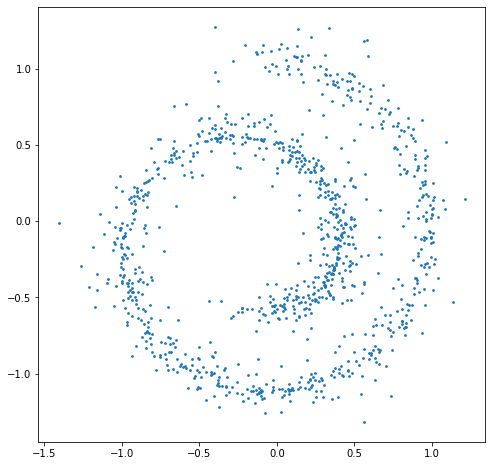

In [42]:
plt.figure(figsize=(8, 8))
plt.scatter(x0[:, 0], x0[:, 1], s=3)
plt.show()